In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import patches

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
pybullet build time: May 20 2022 19:45:31


In [2]:
@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return eqx.filter_vmap(ensemble.psi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_phi(ensemble, s):
    return eqx.filter_vmap(ensemble.phi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_latent_z(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_latent_zz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zz)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, z=None))
def eval_ensemble_icvf_gotil(ensemble, s, z):
    return eqx.filter_vmap(ensemble.gotil)(s, z)


@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - whole traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)

In [3]:
def generate_maze_img(ax, fig, n=50, icvf_values="not", state_list=None):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    S =  env.env.env._wrapped_env._maze_size_scaling
    points = XY(env, n=n)
    # x = np.round(points[:, 0]).reshape(100, 100)
    # y = np.round(points[:, 1]).reshape(100, 100)
    if state_list is None:
        whole_grid = d4rl_ds['observations'][-1]
    else:
        whole_grid = state_list[-5]
    whole_grid = np.tile(whole_grid, (points.shape[0], 1))
    whole_grid[:, :2] = points
    
    if icvf_values is None:
        Z = np.random.rand(n, n)
    else:
        Z = get_v_zz_heatmap(icvf_model, whole_grid, state_list).mean(0)
    im = ax.pcolormesh(points[:,0].reshape(n, n), points[:, 1].reshape(n, n), Z.reshape(n, n), edgecolor='black', shading='nearest')
    
    for i in range(len(env.env.env._wrapped_env._maze_map)):
        for j in range(len(env.env.env._wrapped_env._maze_map[0])):
            struct = env.env.env._wrapped_env._maze_map[i][j]
            if struct == 1:
                rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                        i * S- torso_y - S/ 2),
                                        S,
                                        S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
                ax.add_patch(rect)
    ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
    ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
    fig.colorbar(im)
    return ax

def get_starting_boundary(env):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    maze_map = env.env.env._wrapped_env._maze_map
    S = env.env.env._wrapped_env._maze_size_scaling
    return (0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(maze_map[0]) * S - torso_x - S/2 - S, len(maze_map) * S - torso_y - S/2 - S)

def XY(env, n=10):
    bl, tr = get_starting_boundary(env)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states

## ICVF pretrained on Antmaze-umaze-diverse-v2

In [4]:
env = gym.make("antmaze-umaze-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

Target Goal:  (1.0576309171155516, 8.543460818857275)


load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.29it/s]


In [5]:
from src.agents import icvf
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=d4rl_ds['observations'][0],
                                     hidden_dims=[256, 256],
                                     load_pretrained_icvf=True)


Extra kwargs: {}


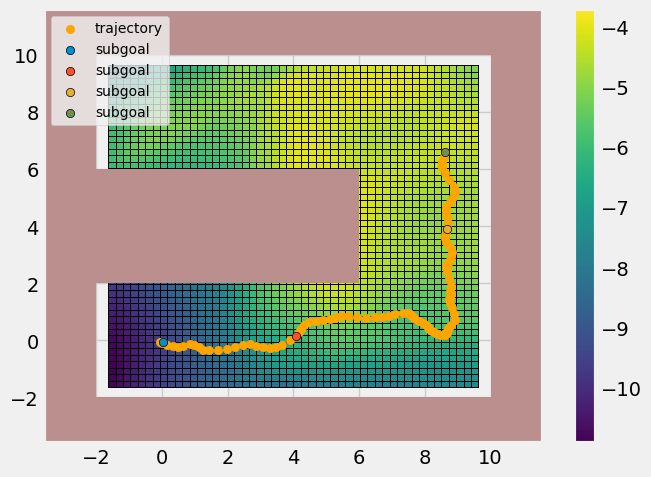

In [6]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))
state_list = d4rl_ds['observations'][np.arange(start=3500, stop=3600)]
SUBGOALS = state_list[[0, 25, 85, 99]]
generate_maze_img(ax, fig, state_list=state_list)

plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [7]:
import jax.numpy as jnp

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

base_observation = jnp.tile(SUBGOALS[-1, :], (state_list.shape[0], 1))
eval_ensemble_icvf_viz(icvf_model.value_learner.model, state_list, base_observation, base_observation).mean(0)

Array([-10.794963  ,  -9.420346  ,  -8.468478  ,  -8.781195  ,
        -8.841913  ,  -9.003918  ,  -8.4215    ,  -8.097468  ,
        -8.149333  ,  -7.567953  ,  -7.9770794 ,  -8.841177  ,
        -8.471791  ,  -8.428262  ,  -7.227848  ,  -6.4803042 ,
        -7.0942173 ,  -6.782666  ,  -8.3670225 ,  -8.632784  ,
        -8.633065  ,  -8.173199  ,  -7.2226787 ,  -7.4717903 ,
        -6.8152122 ,  -6.160347  ,  -6.2600026 ,  -6.5340137 ,
        -6.251856  ,  -6.73351   ,  -6.6570315 ,  -6.746784  ,
        -7.0805836 ,  -7.3962736 ,  -7.422643  ,  -6.736514  ,
        -6.8053575 ,  -7.0585465 ,  -6.638567  ,  -6.95018   ,
        -6.9502296 ,  -6.696879  ,  -7.16856   ,  -7.0913777 ,
        -7.149267  ,  -6.8525324 ,  -6.955645  ,  -6.488896  ,
        -6.8555307 ,  -6.894894  ,  -6.897341  ,  -7.0408707 ,
        -7.215147  ,  -7.341092  ,  -7.190255  ,  -7.7071395 ,
        -7.902267  ,  -6.9402084 ,  -7.2789145 ,  -6.6282187 ,
        -6.7902594 ,  -6.390601  ,  -5.990594  ,  -6.14

### Antmaze-Large-diverse

In [8]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])
for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

Target Goal:  (32.25203200682954, 24.63646264574172)


load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.27it/s]


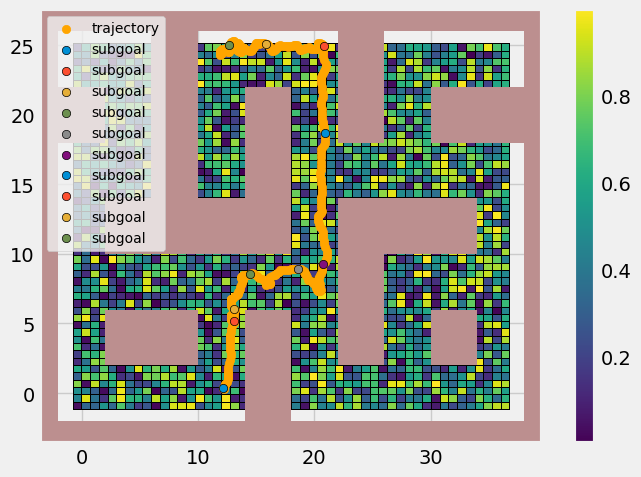

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 5))
generate_maze_img(ax, fig, icvf_values=None)

state_list = d4rl_ds['observations'][np.arange(start=10000, stop=10500)]
SUBGOALS = state_list[[0, 30, 50, 80, 115, 145, 190, 220, 260, 299]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


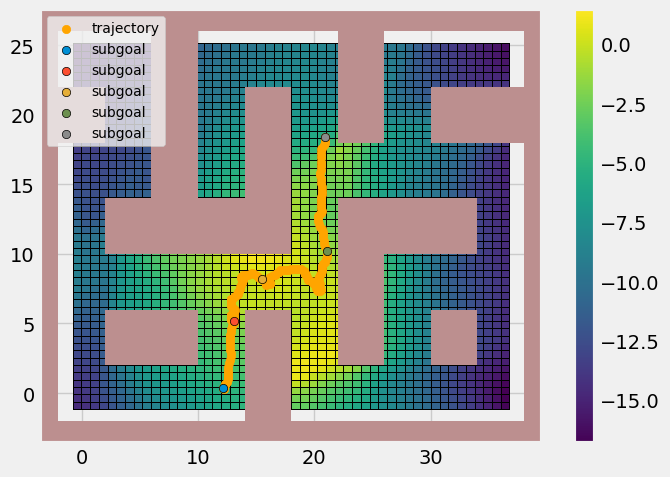

In [10]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))

state_list = d4rl_ds['observations'][np.arange(start=10000, stop=10190)] #(start=10000, stop=10190) np.arange(start=43000, stop=43350)
generate_maze_img(ax, fig, state_list=state_list)

SUBGOALS = state_list[[0, 30, 85, 150, 189]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [11]:
state_list = d4rl_ds['observations'][np.arange(start=10000, stop=10190)]
SUBGOALS = state_list[[0, 30, 85, 150, 189]]
base_observation = jnp.tile(SUBGOALS[-1, :], (state_list.shape[0], 1))
eval_ensemble_icvf_viz(icvf_model.value_learner.model, state_list, base_observation, base_observation).mean(0)

Array([-17.478256  , -17.30465   , -16.869465  , -17.08562   ,
       -17.106853  , -16.749825  , -15.932642  , -15.784133  ,
       -15.869335  , -16.137762  , -15.722016  , -16.013878  ,
       -14.963801  , -14.449097  , -15.1678505 , -14.533704  ,
       -14.031532  , -13.504276  , -13.535313  , -14.106272  ,
       -15.404299  , -15.228119  , -13.764406  , -13.973988  ,
       -14.876314  , -14.493058  , -14.62711   , -13.719923  ,
       -12.861698  , -13.276011  , -14.17146   , -14.835335  ,
       -14.86113   , -14.572462  , -13.621906  , -13.432923  ,
       -14.815858  , -14.251545  , -14.195176  , -15.89215   ,
       -15.528644  , -14.355104  , -13.732457  , -14.0825    ,
       -14.013701  , -13.615461  , -12.944752  , -12.640871  ,
       -11.762817  , -12.773877  , -14.242939  , -14.14267   ,
       -13.273567  , -14.575469  , -13.660196  , -13.204073  ,
       -12.959467  , -12.67205   , -12.591806  , -12.412264  ,
       -11.785583  , -11.297546  , -11.052043  , -12.13

In [64]:
for sg in SUBGOALS:
    sg_repr = np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, sg[None]) - eval_ensemble_psi(icvf_model.value_learner.model, SUBGOALS[-1][None]))
    sg_value = get_v_zz(icvf_model, sg[None], SUBGOALS[-1, :][None])
    print(f"Value: {sg_value}", f"Norm: {sg_repr}")

Value: [-29.196423] Norm: 15.406472206115723
Value: [-16.59612] Norm: 15.315889358520508
Value: [-0.4990456] Norm: 14.732231140136719
Value: [-0.07210147] Norm: 11.71440315246582
Value: [5.7540736] Norm: 0.0


In [ ]:
%matplotlib inline

rews = []
idx = 1
sg = SUBGOALS[idx]
eps = 0.5
subgoal_switches = []
vals = []

for i, state in enumerate(state_list[1:]):
    reward = 0
    old_idx = idx
    idx = np.argmax([get_v_zz(icvf_model, state[None], sg[None]) for sg in SUBGOALS])
    if old_idx != idx:
        subgoal_switches.append(i)
    sg = SUBGOALS[min(idx + 1, len(SUBGOALS) - 1)] # set next subgoal candidate
    
    if get_v_zz(icvf_model, state[None], sg[None]) <= eps:
        reward += 0.2

    val_to_sg = get_v_zz(icvf_model, state[None], sg[None]) # negative value
    vals.append(val_to_sg)
    last_val_to_sg = get_v_zz(icvf_model, state_list[i][None], sg[None]) # negative value
    val_diff = np.array(val_to_sg - last_val_to_sg).item()
    reward -= 0.2 * val_diff
    rews.append(reward)

print(subgoal_switches)
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].set_title('Rewards from ICVF Subgoal Progress')
axs[1].set_title('State Trajectory and Subgoals')
axs[2].set_title('Local Subgoal Values')
axs[0].plot(rews)

for i in subgoal_switches:
    axs[0].axvline(x=i, color='r', linestyle='--')
    
axs[1].plot(state_list[:, 0], state_list[:, 1], color='b')
axs[1].scatter(SUBGOALS[:, 0], SUBGOALS[:, 1], color='r')
axs[2].plot(vals)
for i in subgoal_switches:
    axs[2].axvline(x=i, color='r', linestyle='--')


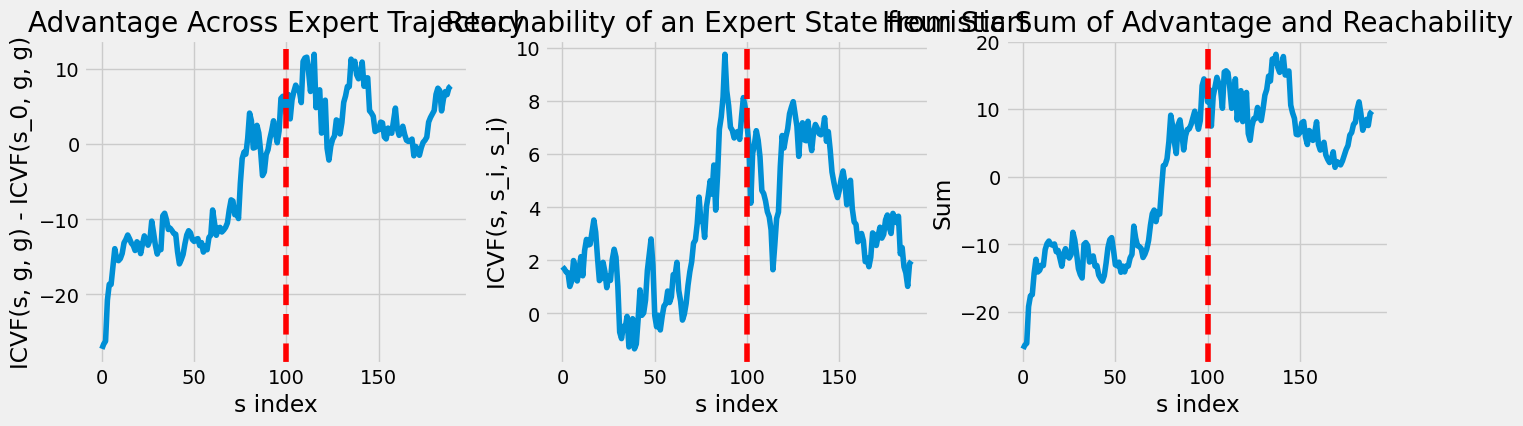

In [14]:
# loop through state list from beginning to end. 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
START_IDX = 100
state_indxs = []
avds  = []
for i, state in enumerate(state_list):
    state_indxs.append(i)
    avds.append(get_v_zz(icvf_model, state[None], SUBGOALS[-1][None]) +  get_v_zz(icvf_model, state_list[START_IDX][None], SUBGOALS[-1][None]))

scale_adv = (np.array(avds) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)

axs[0].plot(state_indxs, avds)
axs[0].set_title('Advantage Across Expert Trajectory')
axs[0].set_ylabel('ICVF(s, g, g) - ICVF(s_0, g, g)')
axs[0].set_xlabel('s index')
axs[0].axvline(x=START_IDX, color='r', linestyle='--')

values  = []
for i, state in enumerate(state_list):
    values.append(get_v_zz(icvf_model, state_list[START_IDX][None], state[None]))

scale_values = (np.array(values) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)

axs[1].plot(state_indxs, values)
axs[1].set_title('Reachability of an Expert State from Start')
axs[1].set_ylabel('ICVF(s, s_i, s_i)')
axs[1].set_xlabel('s index')
axs[1].axvline(x=START_IDX, color='r', linestyle='--')

a, b = 1, 1

def h_test(adv, val):
    scale_values = (np.array(val) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)
    # scale_adv = (np.array(adv) - np.min(avds)) / (np.max(avds) - np.min(avds) + 1e-8)
    scale_adv = (np.array(adv) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)
    return a*scale_adv * b*(1 - scale_values)

heuristic  = [(a * adv) + (b * val) for adv, val in zip(avds, values)]
# heuristic = [h_test(adv, val) for adv, val in zip(avds, values)]
axs[2].plot(state_indxs, heuristic)
axs[2].set_title('Heuristic Sum of Advantage and Reachability')
axs[2].set_ylabel('Sum')
axs[2].set_xlabel('s index')
axs[2].axvline(x=START_IDX, color='r', linestyle='--')


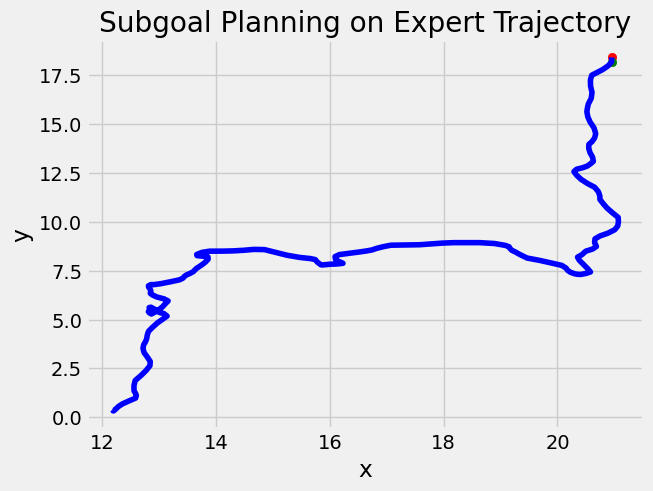

In [15]:
import matplotlib.animation as animation 

from IPython.display import HTML

a, b = 1, 1.1
state_indxs = []
fig, ax = plt.subplots()
ax.set_title('Subgoal Planning on Expert Trajectory')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(state_list[:, 0], state_list[:, 1], color='b')
scat = ax.scatter(state_list[0, 0], state_list[0, 1], color='r')
abc = None

def animate(i):
    global abc
    scat.set_offsets(state_list[i, :2])
    values  = []
    for j, state in enumerate(state_list[i+1:]):
        res = get_v_zz(icvf_model, state_list[i][None], state[None])
        values.append(res)
    avds = []
    for j, state in enumerate(state_list[i+1:]):
        state_indxs.append(j)
        value = get_v_zz(icvf_model, state[None], SUBGOALS[-1, :][None])
        # print(value)
        # print(get_v_zz(icvf_model, state_list[i][None], SUBGOALS[-1,:][None]))
        avds.append(value + (-1) * get_v_zz(icvf_model, state_list[i][None], SUBGOALS[-1,:][None]))
    #heuristic  = [a * adv + b * val for adv, val in zip(avds, values)]
    #print(heuristic)
    #print(avds)
    #print('done')
    if len(state_list[i+1:]) !=0:
        max_idx = np.argmin(avds)
        if abc is not None:
            abc.set_visible(False)
        abc = ax.scatter(state_list[max_idx + i, 0], state_list[max_idx + i, 1], color='g')
    return scat,

anim = animation.FuncAnimation(fig, animate, frames=len(state_list), interval=200, blit=True)


HTML(anim.to_html5_video())


In [26]:
%matplotlib inline

scales_shifts = [(6, 40), (-6, 230)]
def scale_and_shift(x, lst):
    return lst[0] * x + lst[1]
    
def plot_traj_image(traj, start, goal, subgoals, bgpath):
    fig, ax = plt.subplots(figsize=(5, 5))
    pimage = plt.imread(bgpath)
    ax.imshow(pimage)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(scale_and_shift(start[0], scales_shifts[0]), scale_and_shift(start[1], scales_shifts[1]), c='g', s=100, label='start')
    ax.scatter(scale_and_shift(goal[0], scales_shifts[0]), scale_and_shift(goal[1], scales_shifts[1]), c='r', s=100, label='goal')
    ax.scatter(scale_and_shift(subgoals[0], scales_shifts[0]), scale_and_shift(subgoals[1], scales_shifts[1]), c='b', s=100, label='candidate subgoals')
    ax.legend(fontsize=10)
    return fig

In [13]:
from src.gc_dataset import GCSDataset
from src.d4rl_utils import get_dataset

dataset = get_dataset(env)
gcsds_params = {"p_currgoal": 0.0, "p_randomgoal": 0.0, "p_trajgoal":1.0, "discount": 0.99, "geom_sample": True, "intent_sametraj": True, "p_samegoal":0.0}
gc_dataset = GCSDataset(dataset, **gcsds_params)

load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.33it/s]


Rewards mean: -0.9938048124313354


In [14]:
sample = gc_dataset.sample(1)

In [15]:
sample['icvf_goals'] # goal

array([[ 3.2190243e+01,  2.4832764e+01,  5.4144186e-01,  9.7270399e-01,
         4.2959759e-03, -1.4190774e-01, -1.8355012e-01,  2.3554133e-01,
         4.8570371e-01, -4.1673388e-02, -5.6089127e-01,  4.5169860e-01,
        -5.2005774e-01, -3.4226662e-01,  9.9652004e-01,  2.7558124e-01,
        -5.2838951e-01,  3.5217419e-01, -1.1611047e+00, -2.3532853e+00,
        -1.2759028e-01, -1.2401496e+00,  5.3464293e-01,  4.5398889e+00,
         1.1438018e+00, -2.4320908e+00, -2.3599366e-02, -3.8141551e+00,
         3.2209857e+00]], dtype=float32)

In [16]:
sample['icvf_desired_goals'] # z = subgoal -> psi(z) = intent

array([[ 3.2679039e+01,  2.4822987e+01,  5.0510210e-01,  9.8503995e-01,
         2.5792187e-02, -1.6504200e-01, -4.2334590e-02, -2.2795072e-01,
         6.7525655e-01, -1.8353985e-01, -5.0573057e-01,  3.6154786e-01,
        -4.9744037e-01,  5.2739668e-01,  1.1476630e+00,  1.4924521e+00,
        -9.2267138e-01,  8.6236024e-01, -4.7262838e-01,  8.2526118e-01,
         4.4782528e-01, -7.0229143e-01,  2.9642920e+00,  4.4141932e+00,
        -2.7506012e-01, -3.0266657e+00, -6.0371637e-01, -3.1066014e-02,
        -2.1656687e+00]], dtype=float32)

In [24]:
def icvf_stat(batch):
    obs = batch["observations"]
    subgoal = batch["icvf_desired_goals"]
    goal = batch["icvf_goals"]
    advantages = get_v_zz(icvf_model, subgoal, goal) - get_v_zz(icvf_model, obs, goal)
    value = get_v_zz(icvf_model, obs, subgoal) - get_v_zz(icvf_model, obs, goal)
    sg_repr_dist = np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, obs) - eval_ensemble_psi(icvf_model.value_learner.model, subgoal))
    sg_repr = eval_ensemble_psi(icvf_model.value_learner.model, subgoal)[0]
    print(sg_repr_dist)
    
    print("V(sg, g, g)=", get_v_zz(icvf_model, goal, subgoal))
    print("V(s, g, g)=", get_v_zz(icvf_model, goal, obs))
    print("V(s, sg, sg)=", get_v_zz(icvf_model, subgoal, obs))
    print("V(sg, s, s)=", get_v_zz(icvf_model, obs, subgoal))
    print("Advantage of going to sg from s: ", advantages)
    
    return advantages, value

4.2406616
V(sg, g, g)= [5.429371]
V(s, g, g)= [5.633003]
V(s, sg, sg)= [0.07920289]
V(sg, s, s)= [3.3621612]
Advantage of going to sg from s:  [-2.1752553]
(Array([-2.1752553], dtype=float32), Array([1.3646234], dtype=float32))


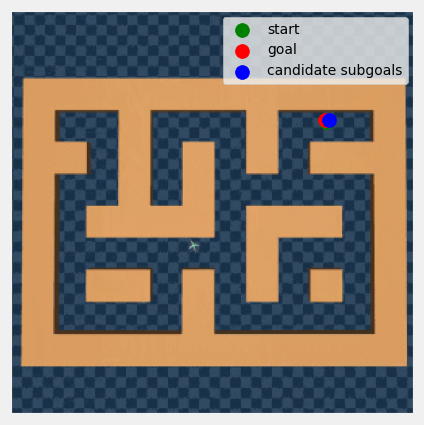

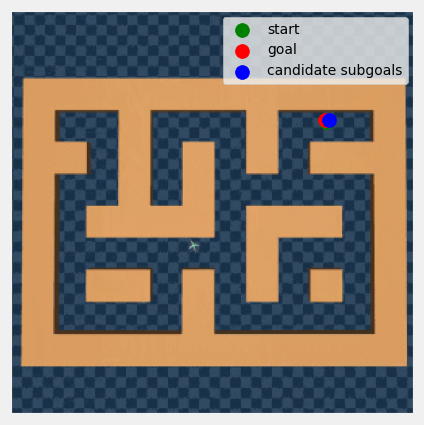

In [28]:
%matplotlib inline

print(icvf_stat(sample))
plot_traj_image(sample, sample['observations'][0], sample['icvf_goals'][0], sample['icvf_desired_goals'][0], "antmaze-large.png")

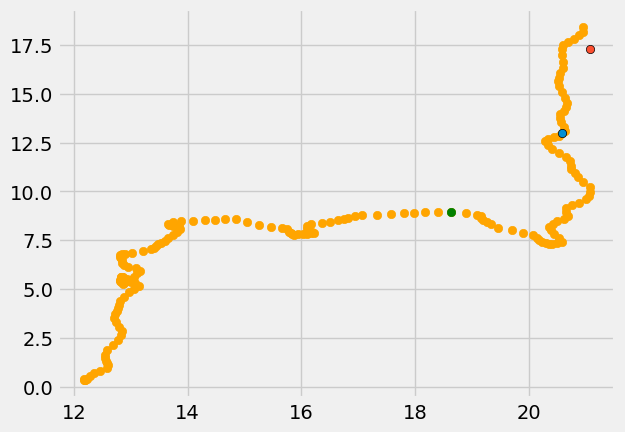

In [35]:
target_subgoal = state_list[165] #3
start_point = state_list[115]
next_start_point = state_list[116]

plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
plt.scatter(*target_subgoal[:2], label="subgoal", edgecolors='black', alpha=1)
plt.scatter(start_point[0], start_point[1], alpha=1, label='start', color='green')

rand_x = np.random.choice(np.linspace(state_list[:,0].min(), state_list[:,0].max(), num=70), size=1)
rand_y = np.random.choice(np.linspace(state_list[:,1].min(), state_list[:,1].max()), size=1)
rand_point = np.random.randn(env.observation_space.shape[0])
rand_point[0] = rand_x
rand_point[1] = rand_y

plt.scatter(*(rand_x, rand_y), label="rnd for ot", edgecolors='black', alpha=1)

In [36]:
print("V(s, sg, sg)=", get_v_zz(icvf_model, target_subgoal[None], start_point[None]))
print("V(ns, sg, sg)=", get_v_zz(icvf_model, target_subgoal[None], next_start_point[None]))

print("V(rand, sg, sg)=", get_v_zz(icvf_model, target_subgoal[None], rand_point[None]))
print("V(rand, s, s)=", get_v_zz(icvf_model, start_point[None], rand_point[None]))
print("V(s, rand, rand)=", get_v_zz(icvf_model, rand_point[None], start_point[None]))

print(f"Distance from start to subgoal: {np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, start_point[None]) - eval_ensemble_psi(icvf_model.value_learner.model, target_subgoal[None]))}")
print(f"Distance from next_state to subgoal: {np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, next_start_point[None]) - eval_ensemble_psi(icvf_model.value_learner.model, target_subgoal[None]))}")

print(f"Distance from rand point to subgoal: {np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, rand_point[None]) - eval_ensemble_psi(icvf_model.value_learner.model, target_subgoal[None]))}")
print(f"Distance from rand point to start: {np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, rand_point[None]) - eval_ensemble_psi(icvf_model.value_learner.model, start_point[None]))}")

V(s, sg, sg)= [-5.2449174]
V(ns, sg, sg)= [-5.3399534]
V(rand, sg, sg)= [-13.577585]
V(rand, s, s)= [-4.9393554]
V(s, rand, rand)= [-14.852325]
Distance from start to subgoal: 10.81808853149414
Distance from next_state to subgoal: 11.170130729675293
Distance from rand point to subgoal: 16.029905319213867
Distance from rand point to start: 17.235998153686523


In [43]:
z_target = eval_ensemble_psi(icvf_model.value_learner.model, target_subgoal[None]).mean(axis=0)
z_rand = eval_ensemble_psi(icvf_model.value_learner.model, rand_point[None])[0].mean(axis=0)

In [44]:
@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_intents(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_viz)(s, g, z) # here z should be latent dim

In [45]:
print(f"Distance between reprs: {eval_ensemble_icvf_intents(icvf_model.value_learner.model, start_point[None], z_target, z_target)[0]}")

Distance between reprs: [-5.2449174]


In [145]:
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

def sink_div(z_rand, z_target):
    geom = pointcloud.PointCloud(z_rand, z_target)
    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        epsilon=0.1,
        x=geom.x,
        y=geom.y,
        static_b=True,
        sinkhorn_kwargs={
            "implicit_diff": imp_diff.ImplicitDiff(),
            "use_danskin": True,
            "max_iterations": 2000
        },
    )
    return ot.divergence

def optimize_OT(z_rand, z_target):
    ot_cost = eqx.filter_jit(eqx.filter_value_and_grad)(sink_div, has_aux=False)
    
    for i in range(40):
        vals, grads_x = ot_cost(z_rand, z_target)
        z_rand -= grads_x * 0.1
    return z_rand

new_z_rand = optimize_OT(z_rand, z_target)
print(np.linalg.norm(jax.device_get(new_z_rand) - eval_ensemble_psi(icvf_model.value_learner.model, target_subgoal)))
print(eval_ensemble_icvf_intents(icvf_model.value_learner.model, start_point[None], new_z_rand, new_z_rand)[0])
print(eval_ensemble_icvf_intents(icvf_model.value_learner.model, start_point[None], z_target, z_target)[0])

0
10
20
30
0.0022115859
[-1.4484926]
[-1.4366479]


In [55]:
from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

import optax

def sink_div(agent_policy, state, y, key) -> tuple[float, float]:
    z_dist = eqx.filter_vmap(agent_policy)(state)
    z = z_dist.sample(seed=key)
    log_prob = z_dist.log_prob(y) #z, log_prob = z_dist.sample_and_log_prob(seed=key)
    geom = pointcloud.PointCloud(x=z, y=y)
    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        x=geom.x,
        y=geom.y,
        epsilon=0.001,
        static_b=True,
        sinkhorn_kwargs={
            "implicit_diff": imp_diff.ImplicitDiff(),
            "use_danskin": True,
            "max_iterations": 3000
        },
    )
    return ot.divergence, log_prob
    
def gradient_flow(
    target_goal: jnp.ndarray,
    cost_fn: callable,
    num_iter: int = 15_000,
    dump_every: int = 1_000
):

    cost_fn_vg = eqx.filter_jit(eqx.filter_value_and_grad(cost_fn, has_aux=True))
    key = jax.random.PRNGKey(42)
    
    actor_intents_learner = TrainStateEQX.create(model=GaussianIntentPolicy(key=key,
                             hidden_dims=[128, 128, 128],
                             state_dim=29,
                             intent_dim=256), optim=optax.adam(learning_rate=3e-4))
    
    z_target = eval_ensemble_psi(icvf_model.value_learner.model, target_goal[None]).mean(axis=0)
    waypoint_indx = 4
    
    for i in tqdm(range(0, num_iter)):
        key, sample_key = jax.random.split(key, 2)
        rand_num = np.random.randint(low=0, high=state_list.shape[0]-1-waypoint_indx)
        x = state_list[rand_num]
        #waypoint = state_list[rand_num + waypoint_indx]
        #y = eval_ensemble_psi(icvf_model.value_learner.model, waypoint).mean(axis=0)
        (cost, log_prob), policy_grads = cost_fn_vg(actor_intents_learner.model, x[None], z_target, sample_key)
        actor_intents_learner = actor_intents_learner.apply_updates(policy_grads)
        
        if i % dump_every == 0:
            z = eqx.filter_vmap(actor_intents_learner.model)(x[None]).sample(seed=sample_key)
            geom = pointcloud.PointCloud(z, z_target, epsilon=0.001)
            diff = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom)).reg_ot_cost
            print(cost, diff)
            print()

    return actor_intents_learner
    
updated_actor_intents_learner = gradient_flow(target_goal=target_subgoal, cost_fn=sink_div)


  0%|          | 0/15000 [00:00<?, ?it/s]

356.65894 351.25424

227.74008 227.03145

172.20496 171.36845

173.2074 172.61801

151.23303 150.59442

139.91655 139.43814

106.871994 106.57422

102.18471 101.90907

89.72319 89.3734

60.029984 59.82112

56.987 56.83734

53.0562 52.81868

53.058746 52.897125

39.168762 39.0002

36.70549 36.56555

29.301529 29.228683

29.949783 29.817795

22.34903 22.228027

25.66565 25.544205

20.844238 20.720673

16.666824 16.55716

18.172485 18.094055

13.959244 13.841278

12.605545 12.524719

10.955246 10.889435

10.85965 10.805923

8.063705 8.014801

7.677124 7.6349487

6.563751 6.521637

6.359009 6.3092194



In [56]:
start_point = state_list[140]
eval_ensemble_icvf_gotil(icvf_model.value_learner.model, start_point[None], z_target).mean(axis=0)

Array([25.665455], dtype=float32)

In [57]:
eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, start_point[None], z_target, z_target)

Array([[0.33324128],
       [0.33324128]], dtype=float32)

In [58]:
eval_ensemble_icvf_viz(icvf_model.value_learner.model, start_point[None], target_subgoal[None], target_subgoal[None])

Array([[0.33324128],
       [0.33324128]], dtype=float32)

In [116]:
def update_low_actor(state, actor_intent_learner):
    key = jax.random.PRNGKey(42)
    actor_learner = TrainStateEQX.create(
            model=GaussianPolicy(key=key,
                                 hidden_dims=[128, 128, 128],
                                 state_dim=env.observation_space.shape[0],
                                 intents_dim=256,
                                 action_dim=env.action_space.shape[0]),
            optim=optax.adam(learning_rate=3e-4)
        )
    
    def optimize_actor(actor_learner, state, next_state, action, sample_key):
        intents = z_target
        intents = jnp.tile(intents, reps=(state.shape[0], 1))
        #eqx.filter_vmap(actor_intent_learner.model)(state).sample(seed=sample_key)
        #intents = #jax.lax.stop_gradient(intents)
        
        v1,v2 = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, state, intents, intents)
        nv1, nv2 = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, next_state, intents, intents)
        v = (v1 + v2) / 2.0
        nv = (nv1 + nv2) / 2.0
        adv = nv - v
        exp_a = jnp.minimum(jnp.exp(adv * 8.0), 100.0)
        exp_a = jax.lax.stop_gradient(exp_a)
        actor_dist = eqx.filter_vmap(actor_learner)(state, intents)
        log_prob = actor_dist.log_prob(action)
        loss = -(exp_a * log_prob).mean()
        return loss, adv.mean()

    actor_loss_fn = eqx.filter_jit(eqx.filter_value_and_grad)(optimize_actor, has_aux=True)
    for i in tqdm(range(3_000)):
        key, sample_key = jax.random.split(key, 2)
        
        rand_num = jax.random.randint(key=sample_key, shape=(128, ), minval=0, maxval=d4rl_ds['observations'].shape[0]-1)
        state = d4rl_ds['observations'][rand_num]
        next_state = d4rl_ds['observations'][rand_num + 1]
        action = d4rl_ds['actions'][rand_num]
        (loss, adv), grads = actor_loss_fn(actor_learner.model, state, next_state, action, sample_key)
        actor_learner = actor_learner.apply_updates(grads)
        if i % 200 == 0:
            print(loss, adv)
    return actor_learner
    
updated_actor = update_low_actor(start_point, updated_actor_intents_learner)

  0%|          | 0/3000 [00:00<?, ?it/s]

203.81374 -0.044876814
203.10748 0.047236115
172.02304 -0.066691294
147.42627 0.037390254
132.8313 0.0034307465
156.91988 -0.0768093
122.06648 -0.0020937007
141.93558 0.17637983
165.35625 0.09034217
149.8641 -0.0006195251
130.28949 -0.008988887
110.071686 -0.021078791
127.98874 -0.10541492
140.31746 0.021112539
120.98856 -0.05812084


In [117]:
sample_key = jax.random.PRNGKey(41)
action = updated_actor.model(start_point.squeeze(), updated_actor_intents_learner.model(start_point).sample(seed=sample_key)).sample(seed=sample_key)

In [118]:
action

Array([-0.52642846, -1.201194  , -0.2808817 , -0.48122507,  0.17730075,
        0.5997158 , -0.07065606, -0.8893619 ], dtype=float32)

## Resetting ENV

In [125]:
start_point = state_list[125]

In [126]:
env.reset()
env.env.env._wrapped_env.set_xy(start_point)
env.env.env._wrapped_env.set_target((target_subgoal[0], target_subgoal[1]))
#env.env.env._wrapped_env._get_obs()

Target Goal:  (32.88306050312317, 24.445900336869872)
Target Goal:  (20.580694, 12.975184)


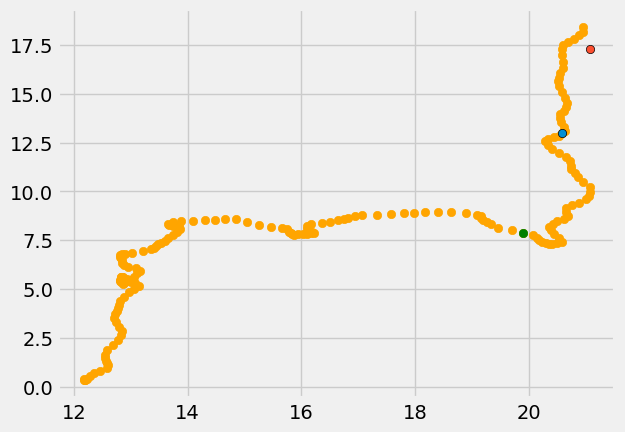

In [127]:
start_point = env.env.env._wrapped_env._get_obs()

plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
plt.scatter(*env.env.env._wrapped_env.target_goal, label="subgoal", edgecolors='black', alpha=1)
plt.scatter(start_point[0], start_point[1], alpha=1, label='start', color='green')
plt.scatter(*(rand_point[0], rand_point[1]), label="rnd for ot", edgecolors='black', alpha=1)

V(s, g, g)= [-3.4469223]
Distance from cur_pos to goal: 13.783474922180176
V(s, g, g)= [-3.0309434]
Distance from cur_pos to goal: 14.891786575317383
V(s, g, g)= [-3.9164333]
Distance from cur_pos to goal: 13.96495532989502
V(s, g, g)= [-4.9046717]
Distance from cur_pos to goal: 14.137017250061035
V(s, g, g)= [-5.4077]
Distance from cur_pos to goal: 12.359668731689453
V(s, g, g)= [-4.8738594]
Distance from cur_pos to goal: 14.930659294128418
V(s, g, g)= [-6.3443704]
Distance from cur_pos to goal: 13.92109489440918
V(s, g, g)= [-4.959674]
Distance from cur_pos to goal: 11.696019172668457
V(s, g, g)= [-6.5127974]
Distance from cur_pos to goal: 15.509495735168457
V(s, g, g)= [-6.005655]
Distance from cur_pos to goal: 14.031740188598633


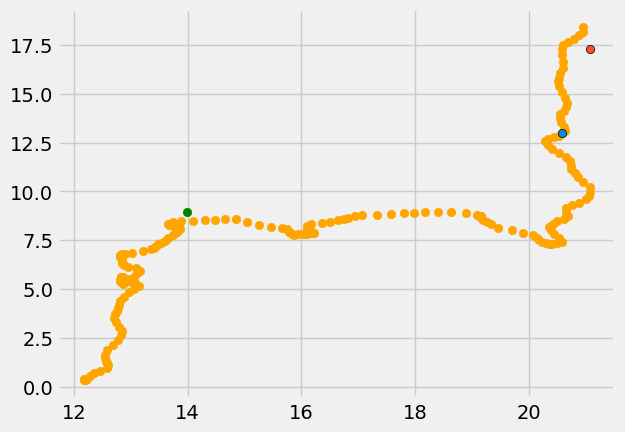

In [129]:
for i in range(200):
    key, sample_key = jax.random.split(sample_key, 2)
    action = jax.device_get(updated_actor.model(start_point.squeeze(), updated_actor_intents_learner.model(start_point).sample(seed=sample_key)).sample(seed=sample_key))
    action = jnp.clip(action, -1, 1)
    new_obs, _, _ ,_ = env.step(action)
    start_point = new_obs
    if i % 20 == 0:
        print("V(s, g, g)=", get_v_zz(icvf_model, target_subgoal[None], start_point[None]))
        print(f"Distance from cur_pos to goal: {np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, start_point[None]) - eval_ensemble_psi(icvf_model.value_learner.model, target_subgoal[None]))}")
    
    
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
plt.scatter(*env.env.env._wrapped_env.target_goal, label="subgoal", edgecolors='black', alpha=1)
plt.scatter(new_obs[0], new_obs[1], alpha=1, label='start', color='green')

plt.scatter(*(rand_point[0], rand_point[1]), label="rnd for ot", edgecolors='black', alpha=1)

### PointMaze

In [100]:
def get_starting_boundary(env):
    S = env.env.env
    return (0, 0), (S.maze_arr.shape[0], S.maze_arr.shape[1])

def XY(env, n=10):
    bl, tr = get_starting_boundary(env)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states
    
def generate_maze_img(ax, fig, state_list, n=50, icvf_values=None):
    S = 1.0
    torso_x = 0.0
    torso_y = 0.0
    points = XY(env, n=n)
    whole_grid = state_list[-1]
    print(whole_grid)
    whole_grid = np.tile(whole_grid, (points.shape[0], 1))
    whole_grid[:, :2] = points
    
    if icvf_values is None:
        Z = np.random.rand(n, n)
    else:
        Z = get_v_zz_heatmap(icvf_model, whole_grid, state_list).mean(0)
    im = ax.pcolormesh(points[:,0].reshape(n, n), points[:, 1].reshape(n, n), Z.reshape(n, n), edgecolor='black', shading='nearest')
    
    for i in range(len(env.env.env.maze_arr)):
        for j in range(len(env.env.env.maze_arr[0])):
            struct = env.env.env.maze_arr[i][j]
            if struct == 10:
                rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                        i * S- torso_y - S/ 2),
                                        S,
                                        S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
                ax.add_patch(rect)
    ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env.maze_arr) * S - torso_x - S/2 - S * 0.6)
    ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env.maze_arr[0]) * S - torso_y - S/2 - S * 0.6)
    fig.colorbar(im)
    return ax

In [108]:
env = gym.make("maze2d-large-dense-v1")
d4rl_pm = d4rl.qlearning_dataset(env)

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


[ 7.7516546   8.956252   -3.7094433   0.12563017]


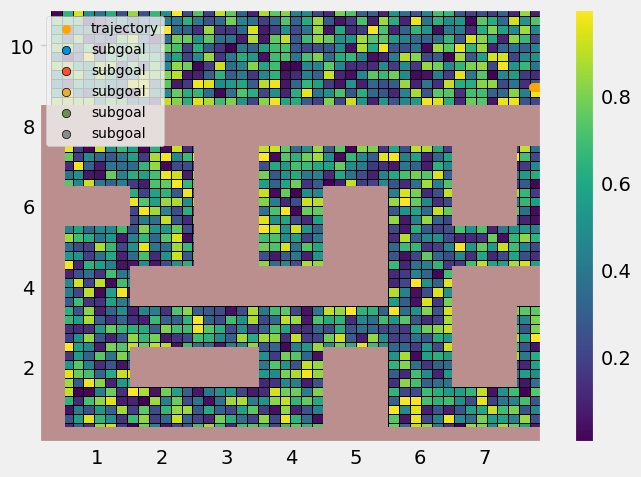

In [109]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))

state_list = h5py.File("/home/m_bobrin/datasets/maze/batch_1/rollout_0.h5", 'r')['traj0']['states']
generate_maze_img(ax, fig, state_list)

SUBGOALS = state_list[[0, 30, 85, 150, 189]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [4]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (32.97756252476421, 24.903303970009457)


load datafile: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.35it/s]


In [5]:
# https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/locomotion/maze_env.py
#env.env.env._wrapped_env??

env.env.env._wrapped_env._maze_map

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 'r', 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
 [1, 0, 0, 1, 0, 0, 0, 1, 0, 'g', 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [6]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

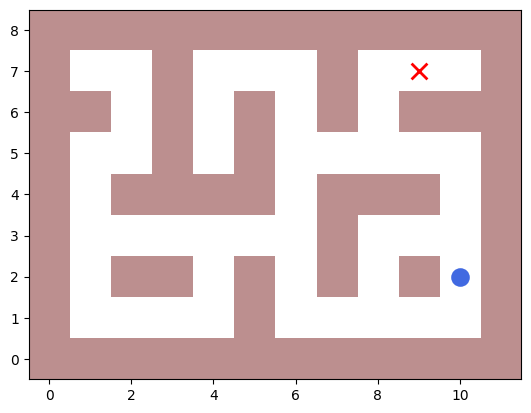

In [7]:
import numpy as np
plt.imshow(1 - np.array(env.env.env._wrapped_env._maze_map), cmap=cmap, origin="lower")
plt.scatter(*env.env.env._wrapped_env._xy_to_rowcol((33.12297854530087, 24.974616400316876))[::-1], marker="x", c='red', s=130, linewidths=2)
plt.scatter(*env.env.env._wrapped_env._xy_to_rowcol((36.376736 ,  5.238806))[::-1], marker="o", c='royalblue', s=130, linewidths=2)

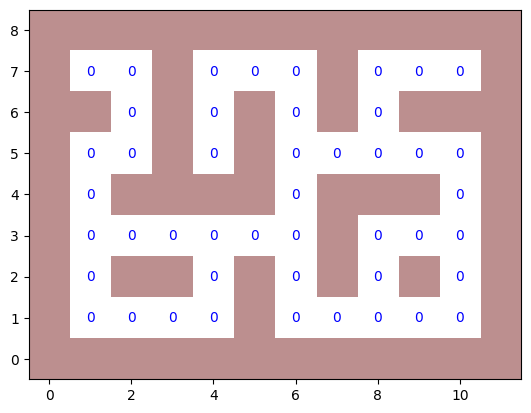

In [8]:
plt.imshow(1 - np.array(env.env.env._wrapped_env._maze_map), cmap=cmap, origin="lower")
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if np.array(env.env.env._wrapped_env._maze_map)[i, j] != 1:
            text = plt.text(j, i, np.array(env.env.env._wrapped_env._maze_map)[i, j],
                           ha="center", va="center", color="b")

In [44]:
xy = d4rl_ds['observations'][np.arange(2000, 2050)][:, :2]

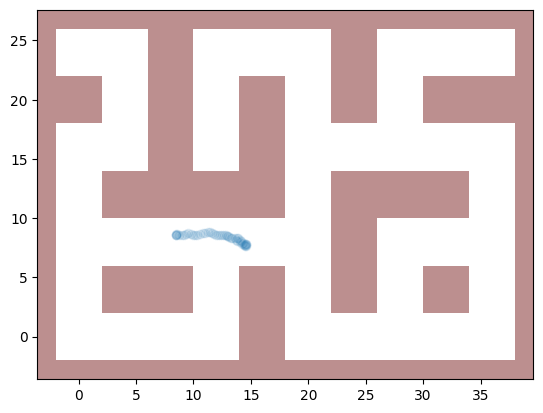

In [46]:
from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)

In [16]:
wrapped_env = env.env.env._wrapped_env
torso_x, torso_y = wrapped_env._init_torso_x, wrapped_env._init_torso_y
S = wrapped_env._maze_size_scaling
print((0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(wrapped_env._maze_map[0]) * S - torso_x - S/2 - S, len(wrapped_env._maze_map) * S - torso_y - S/2 - S))

def XY(n=20):
    bl, tr = (-2.0, -2.0), (38.0, 26.0)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states

(-2.0, -2.0) (38.0, 26.0)


In [23]:
obs = XY()

## AntMaze-Umaze

In [3]:
env = gym.make("antmaze-umaze-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (0.7241989442597729, 8.374488737841759)


load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.36it/s]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

xy = d4rl_ds['observations'][np.arange(700, 800)][:, :2]

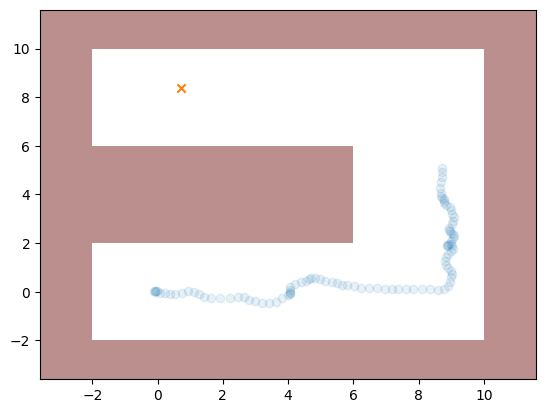

In [9]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)
plt.scatter(*env.env.env._wrapped_env.target_goal, marker="x")

In [5]:
dones_float = np.zeros_like(d4rl_ds['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1

In [6]:
np.nonzero(dones_float)[0][:300]

array([   699,   1399,   2099,   2799,   3499,   4199,   4899,   5599,
         6299,   6999,   7699,   8399,   9099,   9799,  10499,  11199,
        11899,  12599,  13299,  13999,  14699,  15399,  16099,  16799,
        17499,  18199,  18899,  19599,  20299,  20999,  21699,  22399,
        23099,  23799,  24499,  25199,  25899,  26599,  27299,  27999,
        28699,  29399,  30099,  30799,  31499,  32199,  32899,  33599,
        34299,  34999,  35699,  36399,  37099,  37799,  38499,  39199,
        39899,  40599,  41299,  41999,  42699,  43399,  44099,  44799,
        45499,  46199,  46899,  47599,  48299,  48999,  49699,  50399,
        51099,  51799,  52499,  53199,  53899,  54599,  55299,  55999,
        56699,  57399,  58099,  58799,  59499,  60199,  60899,  61599,
        62299,  62999,  63699,  64399,  65099,  65799,  66499,  67199,
        67899,  68599,  69299,  69999,  70699,  71399,  72099,  72799,
        73499,  74199,  74899,  75599,  76299,  76999,  77699,  78399,
      

In [3]:
env = gym.make("antmaze-umaze-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (1.236760811266488, 8.374969640435834)


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.33it/s]


In [7]:
import h5py
from tqdm.auto import tqdm

def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

def get_dataset(h5path):
    data_dict = {}
    with h5py.File(h5path, 'r') as dataset_file:
        for k in tqdm(get_keys(dataset_file), desc="load datafile"):
            try:  # first try loading as an array
                data_dict[k] = dataset_file[k][:]
            except ValueError as e:  # try loading as a scalar
                data_dict[k] = dataset_file[k][()]

    return data_dict
    
random_agent_ds = get_dataset("/home/m_bobrin/AILOT/antmaze-umaze-v2-noiserandomaction.hdf5")

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.29it/s]


In [78]:
xy = combined['observations'][np.arange(203000, 204000)][:, :2]

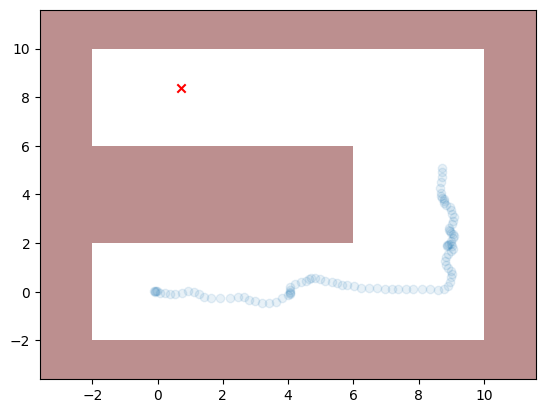

In [12]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)
plt.scatter(*env.env.env._wrapped_env.target_goal, marker="x", c='red')

In [17]:
def combine_ds(expert_ds, agent_ds):
    expert_timeouts = np.nonzero(dones_float)[0] #np.nonzero(expert_ds['dones_float'])[0] # Timeouts = Not neccesarly achived target goal & received reward
    agent_timeouts = np.nonzero(agent_ds['timeouts'])[0]
    num_expert_trajectories = 500 # each trajectory of size 1k; timeout on each of 700 steps, thus 700 * 500=350k
    num_agent_trajectories = 200
    expert_slice = 700 * num_expert_trajectories
    agent_slice = 1000*num_agent_trajectories

    print(agent_timeouts[:num_agent_trajectories])
    mixed_ds = {
        'observations': np.concatenate((agent_ds['observations'][:agent_slice], expert_ds['observations'][:expert_slice])),
        'next_observations': np.concatenate((agent_ds['next_observations'][:agent_slice], expert_ds['next_observations'][:expert_slice])),
        'rewards': np.concatenate((agent_ds['rewards'][:agent_slice], expert_ds['rewards'][:expert_slice])),
        'actions': np.concatenate((agent_ds['actions'][:agent_slice], expert_ds['actions'][:expert_slice])),
        'terminals': np.concatenate((agent_ds['terminals'][:agent_slice], expert_ds['terminals'][:expert_slice])),
        'dones_float': np.concatenate((agent_timeouts[:num_agent_trajectories], expert_timeouts[:num_expert_trajectories]))
    }
    return mixed_ds
    
combined = combine_ds(d4rl_ds, random_agent_ds)

[  1000   2001   3002   4003   5004   6005   7006   8007   9008  10009
  11010  12011  13012  14013  15014  16015  17016  18017  19018  20019
  21020  22021  23022  24023  25024  26025  27026  28027  29028  30029
  31030  32031  33032  34033  35034  36035  37036  38037  39038  40039
  41040  42041  43042  44043  45044  46045  47046  48047  49048  50049
  51050  52051  53052  54053  55054  56055  57056  58057  59058  60059
  61060  62061  63062  64063  65064  66065  67066  68067  69068  70069
  71070  72071  73072  74073  75074  76075  77076  78077  79078  80079
  81080  82081  83082  84083  85084  86085  87086  88087  89088  90089
  91090  92091  93092  94093  95094  96095  97096  98097  99098 100099
 101100 102101 103102 104103 105104 106105 107106 108107 109108 110109
 111110 112111 113112 114113 115114 116115 117116 118117 119118 120119
 121120 122121 123122 124123 125124 126125 127126 128127 129128 130129
 131130 132131 133132 134133 135134 136135 137136 138137 139138 140139
 14114

In [18]:
combined['dones_float']

array([  1000,   2001,   3002,   4003,   5004,   6005,   7006,   8007,
         9008,  10009,  11010,  12011,  13012,  14013,  15014,  16015,
        17016,  18017,  19018,  20019,  21020,  22021,  23022,  24023,
        25024,  26025,  27026,  28027,  29028,  30029,  31030,  32031,
        33032,  34033,  35034,  36035,  37036,  38037,  39038,  40039,
        41040,  42041,  43042,  44043,  45044,  46045,  47046,  48047,
        49048,  50049,  51050,  52051,  53052,  54053,  55054,  56055,
        57056,  58057,  59058,  60059,  61060,  62061,  63062,  64063,
        65064,  66065,  67066,  68067,  69068,  70069,  71070,  72071,
        73072,  74073,  75074,  76075,  77076,  78077,  79078,  80079,
        81080,  82081,  83082,  84083,  85084,  86085,  87086,  88087,
        89088,  90089,  91090,  92091,  93092,  94093,  95094,  96095,
        97096,  98097,  99098, 100099, 101100, 102101, 103102, 104103,
       105104, 106105, 107106, 108107, 109108, 110109, 111110, 112111,
      